- n x n マス空間に幅１マスの道があり、それ以外のマスは落とし穴。
- 道は右下に向かって伸びている。
- ゴールはnマス先にある。
- エージェントはスタート地点から①下に移動　②右に移動　のどちらかを選んで行動する。
- ゴールすると+1の報酬が得られる。途中で落とし穴に落ちるとスタート地点からやり直し。

In [1]:
import numpy as np

def random_action():
    '''
    ランダムな行動
      [1,0] : 下に進む
      [0,1] : 右に進む
    '''
    rand = np.random.random(1)
    return np.eye(2)[int(np.floor(rand+0.5))].astype(int)

def transition(s,a):
    return s + a

In [24]:
# ゴールまでの距離
#nb_step = 15
nb_step = 20

# ゴールの数
#nb_goals = 2
nb_goals = 3

In [38]:
# 答えの初期化
fall_marker = 0
ground_truth = np.ones((nb_step, nb_step), dtype=int)
ground_truth = ground_truth * fall_marker

for _ in range(nb_goals):
    # 初期状態は座標(0,0)とする。
    state = np.zeros(2, dtype=int)

    # 開始位置の値は2にする（色分けのため）。
    start_marker = 2
    ground_truth[state[0], state[1]] = start_marker

    # ゴールまでの道中を1にする。
    ontheway_marker = 1
    for i in range(nb_step):
#        print(i, state)
        state = transition(state, random_action())
        ground_truth[state[0], state[1]] = ontheway_marker

    # ゴールの値は3。state=3で報酬が+1される。
    goal_marker = 3
    ground_truth[state[0], state[1]] = goal_marker

ground_truth

array([[2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 3, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0,

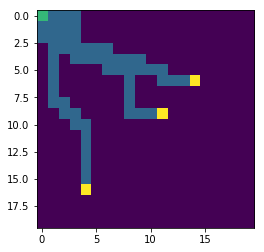

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(ground_truth, interpolation='nearest')

# value functionをEvery-Visit MC法で学習する

In [40]:
# モンテカルロサンプリングの数
mc_step = 300000

# 最大更新回数
max_update = 30

# 割引率
gamma = 1. - 1. / float(nb_step)

# 学習率
learning_rate = 0.25

# 考えうる状態の数はground_truthの大きさと同じ（もう少し小さいが、面倒なので同じとする）
value_table = np.zeros_like(ground_truth, dtype=float)

In [41]:
def get_reward(ground_truth, state, ontheway, goal):
    if ground_truth[state[0], state[1]]==ontheway:
        # 道中の報酬は0
        reward = 0
    elif ground_truth[state[0], state[1]]==goal:
        # ゴールにたどり着いたら報酬は+1
        reward = 1
    else:
        # 落とし穴に落ちたら報酬は-1（使わない。落ちたことを判定するためにreward=-1にしただけ）
        reward = -1
    return reward

In [44]:
from tqdm import tqdm

stacked_value_table = []
isSuccessed = False

value_table = np.zeros_like(value_table) # state valueの初期化（念のためループ直前でも初期化する）
try:
    for i in tqdm(range(mc_step)):
        # 状態の初期化
        state = np.zeros(2, dtype=int)

        reward = 0
        stacked_states = []
        stacked_rewards = []
        while reward >= 0:
            # ランダムな行動を取る。
            action = random_action()

            # 状態の遷移（マス目の移動）
            state = transition(state, action)

            # 報酬の計算
            reward = get_reward(ground_truth, state, ontheway_marker, goal_marker)
            stacked_states.append(state)
            stacked_rewards.append(reward)

            if reward>0:
                '''
                ゴールまでたどり着いたら道中のstate valueを更新する。
                '''
                isSuccessed = True
                R = 0
                for s,r in zip(reversed(stacked_states), reversed(stacked_rewards)):
                    # ゴールから遠いstateには割引されたrewardを与える。
                    R = r + gamma * R

                    # state valueを更新する。
                    V = value_table[s[0], s[1]]
                    value_table[s[0], s[1]] = V + learning_rate * (R - V)

                # state valueが更新されるたびにその値を保存しておく（学習過程の可視化のため）。
                # なお、np.copy()を使わないとリスト中のすべてのvalue_tableが同じ値になってしまう。
                stacked_value_table.append(np.copy(value_table))
                
        if len(stacked_value_table)==max_update:
            raise Exception
            
except Exception:
    pass

 23%|██▎       | 67819/300000 [00:03<00:12, 17993.12it/s]


# 学習過程の可視化
- Every-Visit MC法ではゴールまでたどり着くたびにvalue functionが更新される。その過程を見る。

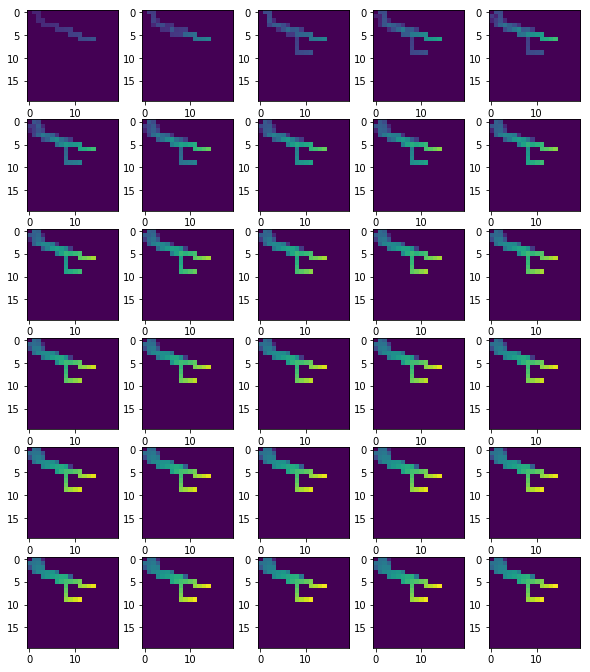

In [45]:
if isSuccessed:
    nb = 0
    plt.figure(figsize=(10,10*int(len(stacked_value_table)+1)/5.))
    for v in stacked_value_table:
        nb += 1
        plt.subplot(int(len(stacked_value_table)+1),5,nb)
        plt.imshow(v, interpolation='nearest')
        plt.clim(0,1)